# Stationary state 4

Tasks: 

- Plot the $E[X(t)]$ curves for various pairs of beta1, beta2
- Contour plot of $k^{*}$ wrt beta1, beta2

- Try with `odeint` solver.

Note: the first two arguments of func are in the opposite order

More notes see [Integration and ODEs](https://docs.scipy.org/doc/scipy/reference/integrate.html) and [odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)
```text
Old API
These are the routines developed earlier for SciPy. They wrap older solvers implemented in Fortran (mostly ODEPACK).
```

```text
Note:
For new code, use `scipy.integrate.solve_ivp` to solve a differential equation.
```

It seems odeint is using `LSODA` see [readme](https://github.com/scipy/scipy/blob/v0.19.0/scipy/integrate/odepack/readme)


Just switch to a faster solver like `LSODA` or [`ode15s` equivalent](https://scipy.github.io/old-wiki/pages/NumPy_for_Matlab_Users.html):

```python
scipy.integrate.ode(f).set_integrator('vode', method='bdf', order=15) 
```

In [6]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
import pickle

import sys
sys.path.append('../tests/')
from test_solving_KEs_complete import *

In [7]:
"""Complete case test."""
# setup
# TODO: increase these values
N = 100
I0 = 10 
time_max = 20

beta1 = 2 / N       # pairwise infection rate
beta2 = 4 / (N**2)  # hyperedge contagion rate
mu    = 1           # recovery rate

print(f"Setup: \n")
print(f"\tH = Complete Hypergraph, N = {N}, I0 = {I0}\n")
print(f"\tbeta1 = {beta1}, beta2 = {beta2}, mu = {mu}\n")

Setup: 

	H = Complete Hypergraph, N = 100, I0 = 10

	beta1 = 0.02, beta2 = 0.0004, mu = 1



In [8]:
i_max = 10
j_max = 10

k_star = np.zeros((i_max, j_max)) # to store the values k^* = E[X(t_max)]

eps = 1e-1 # shift for esp to not start with 0 !

beta1_vec = (np.array(list(range(i_max))) + eps) / N
beta2_vec = (np.array(list(range(j_max))) + eps) / (N**2)

print(f"beta1: {beta1_vec[:5]}, ..., {beta1_vec[-3:-1]}")
print(f"beta2: {beta2_vec[:5]}, ..., {beta2_vec[-3:-1]}")

beta1: [0.001 0.011 0.021 0.031 0.041], ..., [0.071 0.081]
beta2: [1.0e-05 1.1e-04 2.1e-04 3.1e-04 4.1e-04], ..., [0.00071 0.00081]


In [9]:
M = N + 1 # number of all states

# set the initial condition
p0 = np.zeros(M)
p0[I0] = 1.0 # all other states have prob 0 at time 0
print(f"p0 = {p0[:20]} ...")

# time range and times to evaluate solution
nsteps = 101
t_span = (0.0, time_max)
t_eval = np.linspace(t_span[0], t_span[1], nsteps)

p0 = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...


In [10]:
solve_for_betas = True
# save solutions to run it once
file_path = '../results/solutions_stationary_state_10x10.pickle'

if solve_for_betas:
    solutions = {}
    for i, beta1 in enumerate(beta1_vec):
        for j, beta2 in enumerate(beta2_vec):
            ode_system_complete = list_all_ODEs_complete(N, beta1, beta2, mu)

            def f_ode(t, p):
                return ode_system_complete(t, p)

            sol = solve_ivp(f_ode, 
                            t_span, 
                            p0, 
                            t_eval=t_eval,
                            method="LSODA"
            )
            solutions[str((i, j))] = sol
    # save the solutions
    with open(file_path, "wb") as f:
        pickle.dump(solutions, f)    
else:
    # load solutions
    with open(file_path, "rb") as f:
        solutions = pickle.load(f)    
    

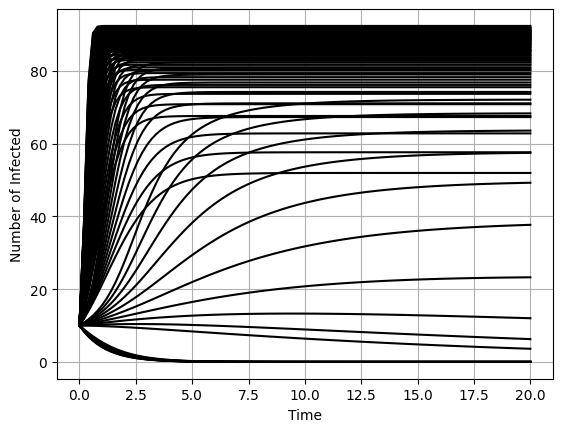

In [11]:
# plot expected values of p_{k}(t) over time t
# if slope < -eps, color it 
# save the bad (beta1, beta2) pair
bad_betas = []
bad_indices = []

k_star = np.zeros((i_max, j_max)) # to store the values k^* = E[X(t_max)]

plt.figure()
for i, beta1 in enumerate(beta1_vec):
    for j, beta2 in enumerate(beta2_vec):
        sol = solutions[str((i, j))]
        expected_values = calculate_expected_values(sol)
        
        k_star[i, j] = expected_values[-1]

        plt.plot(sol.t, expected_values, color="k")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
# plt.legend() # no legend
plt.grid(True)
plt.savefig("../figures/solutions-kolmogorov/complete/stationary-state_50x50.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

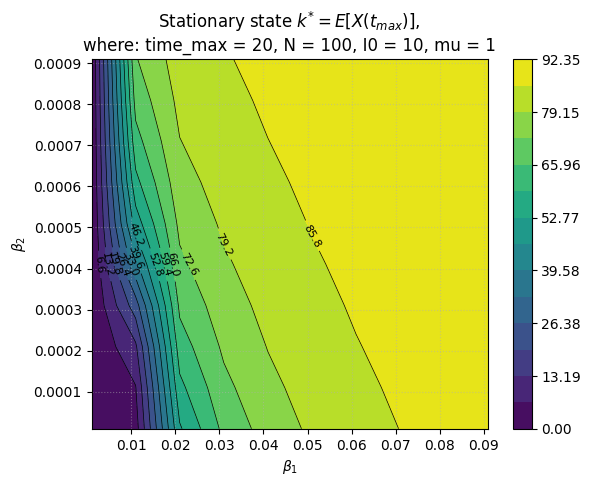

In [ ]:
B1, B2 = np.meshgrid(beta1_vec, beta2_vec)
plt.figure()
levels = np.linspace(k_star.min(), k_star.max(), 15) # TODO: set levels

contourf_plot = plt.contourf(B1, B2, k_star.T, levels=levels, cmap='viridis') # use k_star.T!!
contour_plot = plt.contour(B1, B2, k_star.T, levels=contourf_plot.levels, colors='k', linewidths=0.5)

plt.clabel(contour_plot, inline=True, fontsize=8, fmt='%.1f')

cbar = plt.colorbar(contourf_plot)
cbar.set_label(r'')

plt_title = r'Stationary state $k^{*} = E[X(t_{max})]$, '
plt_title += f"\nwhere: time_max = {time_max}, N = {N}, I0 = {I0}, mu = {mu}"
plt.xlabel(r'$\beta_1$')
plt.ylabel(r'$\beta_2$')
plt.title(plt_title)
plt.grid(True, linestyle=':', alpha=0.5)
plt.savefig("../figures/solutions-kolmogorov/complete/stationary-state-contour_50x50.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()